# eTransafe Terbinafine Heatmap

This is the use scenario that has been described in the mid term review for exploring the differences with respect to adverse events between terbinafine preclinical and clinical. In order to compute these results the following scenario is executed:
1. authenticate with the eTransafe keycloak
2. Translate the provided compound to a SMILES
3. Retrieve similar compounds based on structural similarity
4. Retrieve data from the preclinical and clinical databases
5. Aggregate the data per system organ class
6. Visualize the data using a heatmap

(C) 2020 Erasmus University Medical Center, Rotterdam, The Netherlands
Author: Erik M. van Mulligen, e.vanmulligen@erasmusmc.nl

In [3]:
import sys  
import knowledgehub
import ipywidgets as w
from IPython.display import display, Markdown, clear_output, Javascript
from ipypublish import nb_setup
import numpy as np
import seaborn as sns
import pandas
import json
import matplotlib.pyplot as plt
from pprint import pprint

In [4]:
api = kh.KnowledgeHubAPI()

# 1. Authentication
Use eTransafe's authentication service to get access to available services

In [5]:
username = w.Text(value='e.vanmulligen@erasmusmc.nl',placeholder='Knowledge Hub account', description='username:', disabled=False)
password = w.Password(value='', placeholder='Knowledge Hub password', description='password:', disabled=False)
loginBtn = w.Button(description='Login')
status = w.Output()

def on_button_clicked(_):
    if api.login(username.value, password.value) == False:
        print("Failed to login")
    else:
        print("successfully logged in")
        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))

loginBtn.on_click(on_button_clicked)
w.VBox([username, password, loginBtn])

successfully logged in


<IPython.core.display.Javascript object>

## 2. Translate compound to SMILES using semantic services
For the entered compound name, retrieve the associated SMILES using the semantic services

In [7]:
textWidget = w.Text(
    value='Hello World',
    placeholder='Type something',
    description='String:',
    disabled=False
)

dropDown = w.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)

select = w.Select(
    options=['Linux', 'Windows', 'OSX', '1', '2', '3'],
    value='OSX',
    rows=5,
    description='OS:',
    disabled=False
)

def on_submit(_):
    print('on_submit')
    res = api.SemanticService().lookup(textWidget.value, ['RxNorm'])
    print(res)
    
textWidget.on_submit(on_submit)
w.VBox([textWidget, dropDown, select])

In [14]:
compoundName = w.Text(value='terbinafine',placeholder='compound name', description='compound:', disabled=False)
compoundBtn = w.Button(description='Retrieve')
compoundSmile = None

def on_compound_entered(_):
        compound = api.SemanticService().normalize(compoundName.value, ['RxNorm','smiles'])
        if 'concepts' in compound:
            for concept in compound['concepts']:
                if 'vocabularyId' in concept:
                    if concept['vocabularyId'] == 'smiles':
                        global compoundSmile
                        compoundSmile = concept['conceptCode']
                        print(f'Found SMILES {compoundSmile} for {compoundName.value}')
                        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))

compoundBtn.on_click(on_compound_entered) 
w.VBox([compoundName, compoundBtn])

Found SMILES CN(CC=CC#CC(C)(C)C)Cc1cccc2ccccc12 for terbinafine


<IPython.core.display.Javascript object>

## 3. Retrieve similar compounds

In [15]:
similar_compounds = api.SimilarityService().get(compoundSmile, nr_results = 20)
compoundIds = []
compoundNames = []
names = []
smiles = []
similarities = []

if similar_compounds != None:
    if ('search_results' in similar_compounds) and (len(similar_compounds['search_results']) == 1):
        search_result = similar_compounds['search_results'][0]
        if 'obj_nam' in search_result:
            for i in range(len(search_result['obj_nam'])):
                names.append(search_result['obj_nam'][i])
                smiles.append(search_result['SMILES'][i])
                similarities.append("{:.4f}".format(search_result['distances'][i]))

            for cmp in search_result['obj_nam']:
                concept = api.SemanticService().normalize(cmp, ['RxNorm'])
                if 'concepts' in concept and len(concept['concepts']) == 1:
                    compoundIds.append(concept['concepts'][0]['conceptCode'])
                    compoundNames.append(concept['concepts'][0]['conceptName'])
        else:
            print('something wrong in the result object from the similarity service')    

pd = nb_setup.setup_pandas(escape_latex=False)
df = pd.DataFrame(np.random.rand(len(names),3),columns=['NAME','SMILES','SIMILARITY'])
df.NAME = names
df.SMILES = smiles
df.SIMILARITY = similarities
df.round(3)

NAME                                          SMILES  \
0            terbinafine            CN(C/C=C/C#CC(C)(C)C)Cc1cccc2ccccc12   
1   Cholestyramine_Resin   CCc1ccc(C(C)CCc2ccc([N+](C)(C)C)cc2)cc1.[Cl-]   
2         Cyproheptadine              CN1CCC(=C2c3ccccc3C=Cc3ccccc32)CC1   
3             Imipramine                   CN(C)CCCN1c2ccccc2CCc2ccccc21   
4           vortioxetine                 Cc1ccc(Sc2ccccc2N2CCNCC2)c(C)c1   
5           Promethazine                  CC(CN1c2ccccc2Sc2ccccc21)N(C)C   
6          Amitriptyline                  CN(C)CCC=C1c2ccccc2CCc2ccccc21   
7        cyclobenzaprine                 CN(C)CCC=C1c2ccccc2C=Cc2ccccc21   
8                Doxepin                  CN(C)CCC=C1c2ccccc2COc2ccccc21   
9             duloxetine               CNCC[C@H](Oc1cccc2ccccc12)c1cccs1   
10             Asenapine                 CN1CC2c3ccccc3Oc3ccc(Cl)cc3C2C1   
11            butenafine          CN(Cc1ccc(C(C)(C)C)cc1)Cc1cccc2ccccc12   
12         desloratadine              Clc1ccc2c(c1)CCc1cccnc1C2=C1CCNCC1   
13      Dextromethorphan  COc1ccc2c(c1)[C@]13CCCC[C@@H]1[C@H](C2)N(C)CC3   
14  Bupivacaine_liposome                  CCCCN1CCCCC1C(=O)Nc1c(C)cccc1C   
15           Bupivacaine                  CCCCN1CCCCC1C(=O)Nc1c(C)cccc1C   
16            Fluoxetine              CNCCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1   
17            Rotigotine            CCCN(CCc1cccs1)[C@H]1CCc2c(O)cccc2C1   
18          Benzalkonium                CCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1   
19           Desipramine                      CNCCCN1c2ccccc2CCc2ccccc21   

   SIMILARITY  
0      1.0000  
1      0.9933  
2      0.9930  
3      0.9857  
4      0.9849  
5      0.9848  
6      0.9839  
7      0.9824  
8      0.9811  
9      0.9797  
10     0.9779  
11     0.9718  
12     0.9712  
13     0.9708  
14     0.9700  
15     0.9700  
16     0.9696  
17     0.9694  
18     0.9693  
19     0.9686

# 4. Retrieve data from the preclinical and clinical databases

In [16]:
studies = api.Medline().getStudiesByCompoundIds(compoundIds) + \
          api.Faers().getStudiesByCompoundIds(compoundIds) + \
          api.ClinicalTrials().getStudiesByCompoundIds(compoundIds) + \
          api.eToxSys().getStudiesByCompoundNames(compoundNames)
print(f'Found {len(studies)} studies.')

Found 8862 studies.


# 5. Aggregate the data per system organ class

Since the eTox data reports events with an organ. We use our own method to map it to MedDRA's system organ class to make it comparable

In [17]:
system = {}
all_compounds = compoundNames
socs = {}

# traverse all studies and collect the system organ classes; keep track of the # studies per class
for study in studies:
    source = study['source']
    if source != 'eTOXsys' or study['FINDING']['finding'] != 'No abnormalities detected':
        specimenOrgans = api.SemanticService().getSocs(study['FINDING']['specimenOrgan'])
        for specimenOrgan in specimenOrgans:
            if len(specimenOrgan) > 0:
                if not specimenOrgan in socs:
                    socs[specimenOrgan] = 1
                else:
                    socs[specimenOrgan] += 1
                    
# sort the socs per count
all_socs = {k: v for k, v in sorted(socs.items(), key=lambda item: item[1], reverse=True)}

# traverse all studies and create a matrix per source
for study in studies:
    source = study['source']
    if not source in system.keys():
        system[source] = {'data':np.zeros((len(all_socs),len(all_compounds)), dtype=int).tolist(), 
                          'rows':list(all_socs.keys()), 
                          'cols':all_compounds}
    
    if source != 'eTOXsys' or study['FINDING']['finding'] != 'No abnormalities detected':
        specimenOrgans = api.SemanticService().getSocs(study['FINDING']['specimenOrgan'])
        for specimenOrgan in specimenOrgans:
            if len(specimenOrgan) > 0:
                row = system[source]['rows'].index(specimenOrgan)
                col = system[source]['cols'].index(study['COMPOUND']['name'])
                system[source]['data'][row][col] += 1
                

# 6. Visualize the data using a heatmap

Using seaborn to visualize the content of the various databases. Note that we have to think about ways to easier compare the various results.

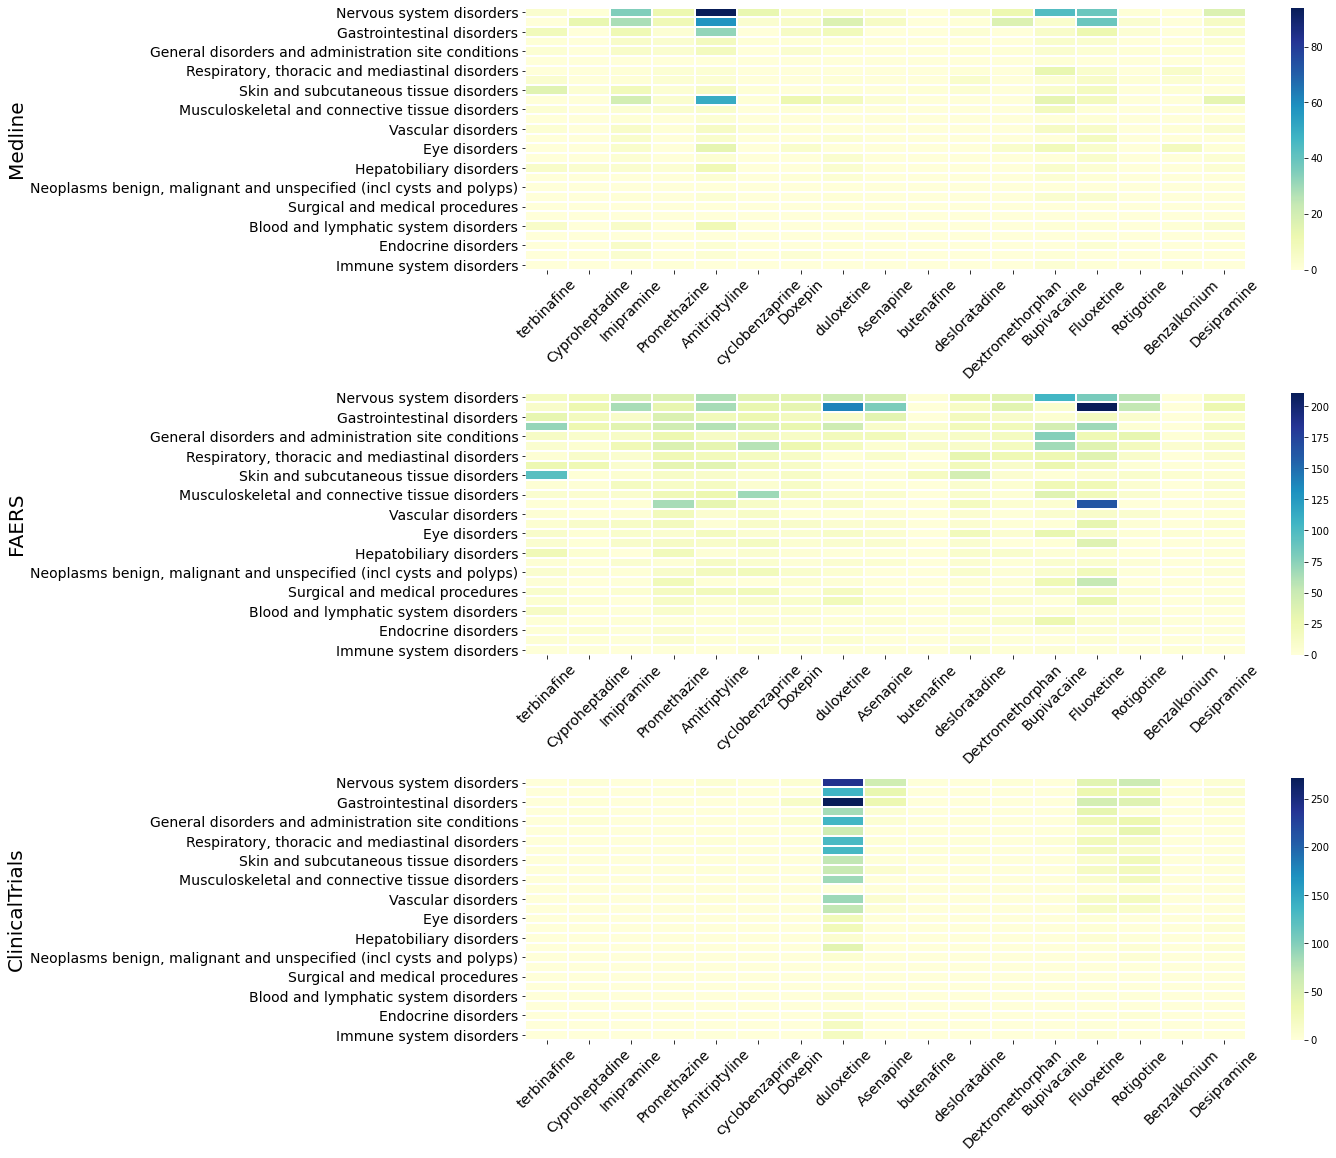

In [18]:
figure, axes = plt.subplots(figsize=(20,20))
i = 1
for source,value in system.items():
    plt.subplot(4, 1, i)
    df = pandas.DataFrame(value['data'], index=value['rows'], columns=value['cols'])
    ax = sns.heatmap(df, linewidths=1.0, cmap="YlGnBu")
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=14, rotation=45)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=14)
    plt.ylabel(source, fontsize=20)
    i += 1

figure.tight_layout()
plt.show()